#Brain Tumor Segmentation - MaskRCNN (Pytorch)

#Loading Dataset

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="AtAN7fsWbxIN9Moql1gJ")
project = rf.workspace("iotseecs").project("brain-tumor-yzzav")
dataset = project.version(1).download("coco-segmentation")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to BRAIN-TUMOR-1 in coco-segmentation:: 100%|██████████| 842/842 [00:00<00:00, 4339.20it/s]


In [ ]:
# Paths to the directories
train_dir = '/content/BRAIN-TUMOR-1/train'
test_dir = '/content/BRAIN-TUMOR-1/test'
valid_dir = '/content/BRAIN-TUMOR-1/valid'

# Get the list of all files in each directory
train_files = [f for f in os.listdir(train_dir) if os.path.isfile(os.path.join(train_dir, f))]
test_files = [f for f in os.listdir(test_dir) if os.path.isfile(os.path.join(test_dir, f))]
valid_files = [f for f in os.listdir(valid_dir) if os.path.isfile(os.path.join(valid_dir, f))]

# Print the total number of images in each directory
print(f"Total number of images in train: {len(train_files)}")
print(f"Total number of images in test: {len(test_files)}")
print(f"Total number of images in valid: {len(valid_files)}")


Total number of images in train: 584
Total number of images in test: 129
Total number of images in valid: 124


#Training Set

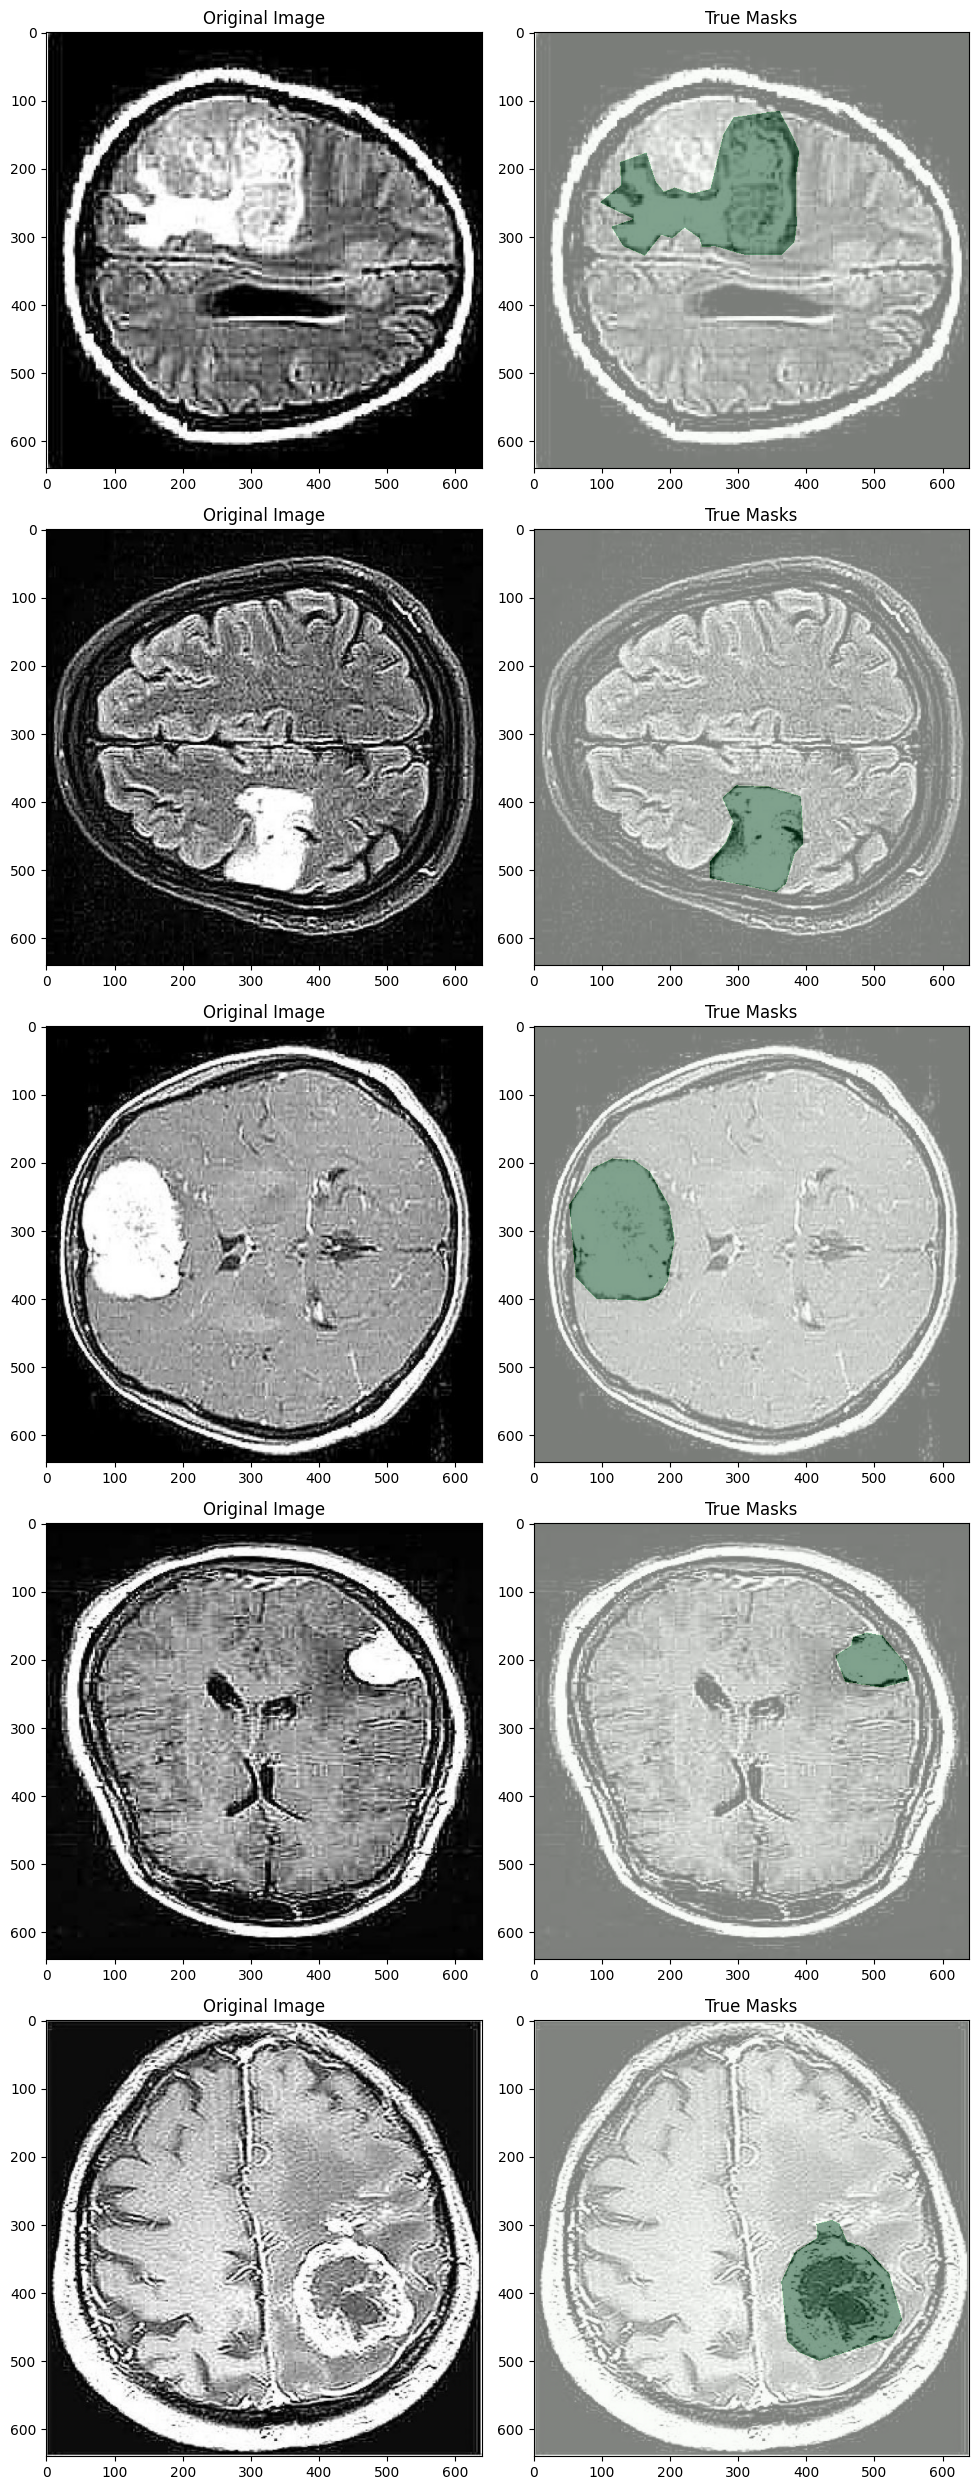

In [ ]:
# Load the COCO annotations for the train dataset
with open('/content/BRAIN-TUMOR-1/train/_annotations.coco.json', 'r') as f:
    annotations = json.load(f)

# Randomly select 5 images
image_ids = [img["id"] for img in annotations["images"]]
selected_image_ids = random.sample(image_ids, 5)

# Create a single plot for all images
fig, axes = plt.subplots(5, 2, figsize=(10, 25))

for idx, image_id in enumerate(selected_image_ids):
    image_info = next(img for img in annotations["images"] if img["id"] == image_id)
    image_path = os.path.join('/content/BRAIN-TUMOR-1/train', image_info["file_name"])

    # Extract true masks for the image
    true_masks = []
    for ann in annotations["annotations"]:
        if ann["image_id"] == image_id:
            mask = np.zeros((image_info["height"], image_info["width"]))
            for seg in ann["segmentation"]:
                poly = np.array(seg).reshape((-1, 2))
                rr, cc = skimage.draw.polygon(poly[:, 1], poly[:, 0])
                mask[rr, cc] = 1
            true_masks.append(mask)

    # Plot the original image
    image = Image.open(image_path).convert("RGB")
    axes[idx, 0].imshow(image)
    axes[idx, 0].set_title("Original Image")

    # Plot the true masks
    if true_masks:
        axes[idx, 1].imshow(image)
        for mask in true_masks:
            axes[idx, 1].imshow(mask, alpha=0.5, cmap='Greens')
        axes[idx, 1].set_title("True Masks")

plt.tight_layout()
plt.show()

In [ ]:
import sys, os, distutils.core

In [ ]:
import torch
import torchvision
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from PIL import Image, ImageDraw
import sys, os
import numpy as np

#COCO Dataset Loading Class

In [ ]:
import random
from pycocotools.coco import COCO

class MaskRCNNDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        # Load image and annotations
        img_id = self.ids[idx]
        anns = self.coco.loadAnns(self.coco.getAnnIds(imgIds=img_id))

        img_path = os.path.join(self.root, self.coco.loadImgs(img_id)[0]['file_name'])
        img = Image.open(img_path).convert("RGB")

        # Processing annotations
        boxes = []
        masks = []
        labels = []

        for ann in anns:
            xmin, ymin, width, height = ann['bbox']
            boxes.append([xmin, ymin, xmin + width, ymin + height])
            masks.append(self.coco.annToMask(ann))
            labels.append(ann['category_id'])

        if len(anns) == 0:
            # Handle images with no annotations
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            masks = torch.zeros((0, img.size[1], img.size[0]), dtype=torch.uint8)
            area = torch.zeros((0,), dtype=torch.float32)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            masks = np.array(masks)  # Convert the list of numpy arrays to a single numpy array
            masks = torch.as_tensor(masks, dtype=torch.uint8)
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # Create a dictionary for the targets
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = torch.tensor([img_id])
        target["area"] = area
        target["iscrowd"] = torch.zeros((len(anns),), dtype=torch.int64)

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

#Custom Transformations - Augmentations

In [ ]:
from torchvision.transforms import functional as F

class CustomTransforms:
    def __init__(self, train=True):
        self.train = train

    def __call__(self, img, target):
        # Convert PIL image to tensor
        img = F.to_tensor(img)

        # Apply random horizontal flip with 50% probability
        if self.train:
            if random.random() < 0.5:
                img = F.hflip(img)
                width = img.shape[-1]
                bbox = target["boxes"]
                bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
                target["boxes"] = bbox
                target["masks"] = target["masks"].flip(-1)

        return img, target

#Loading Training and Validation Parts

In [ ]:
from torchvision.transforms import functional as F

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

def transformed_collate(batch):
    images, targets = zip(*batch)
    return list(images), list(targets)

# Dataset and DataLoader
# Dataset and DataLoader
train_transform = CustomTransforms(train=True)
val_transform = CustomTransforms(train=False)

train_dataset_maskrcnn = MaskRCNNDataset(root='/content/BRAIN-TUMOR-1/train',
                                         annotation='/content/BRAIN-TUMOR-1/train/_annotations.coco.json',
                                         transforms=train_transform)

val_dataset_maskrcnn = MaskRCNNDataset(root='/content/BRAIN-TUMOR-1/valid',
                                       annotation='/content/BRAIN-TUMOR-1/valid/_annotations.coco.json',
                                       transforms=val_transform)

train_loader_maskrcnn = DataLoader(train_dataset_maskrcnn, batch_size=8, shuffle=True, num_workers=4, collate_fn=transformed_collate)
val_loader_maskrcnn = DataLoader(val_dataset_maskrcnn, batch_size=8, shuffle=False, num_workers=4, collate_fn=transformed_collate)


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


#Training & Evaluation Functions

In [ ]:
import time
import torch

def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    total_train_loss = 0
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]



        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        total_train_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(data_loader)
    return avg_train_loss

def evaluate(model, data_loader, device):
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for images, targets in data_loader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Force the model to return losses
            model.train()
            loss_dict = model(images, targets)
            model.eval()

            losses = sum(loss for loss in loss_dict.values())
            total_val_loss += losses.item()

    avg_val_loss = total_val_loss / len(data_loader)
    return avg_val_loss



#Using MaskRCNN - Pretrained (Pytorch)

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights


def build_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Stop here if you are fine-tunning Faster-RCNN

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

#Training

In [ ]:


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Initialize the model and optimizer
model = build_model(num_classes=2)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0003, momentum=0.9, weight_decay=1e-6)

# Main training loop with validation
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    start_time = time.time()
    train_loss = train_one_epoch(model, optimizer, train_loader_maskrcnn, device)
    val_loss = evaluate(model, val_loader_maskrcnn, device)
    end_time = time.time()

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Time: {end_time-start_time:.4f} s")




The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:00<00:00, 383MB/s]


Epoch: 1/50, Train Loss: 0.8320, Validation Loss: 0.4779, Time: 128.1753 s
Epoch: 2/50, Train Loss: 0.4484, Validation Loss: 0.3873, Time: 131.4325 s
Epoch: 3/50, Train Loss: 0.3589, Validation Loss: 0.3180, Time: 131.5442 s
Epoch: 4/50, Train Loss: 0.2953, Validation Loss: 0.2726, Time: 131.5780 s
Epoch: 5/50, Train Loss: 0.2604, Validation Loss: 0.2573, Time: 131.1919 s
Epoch: 6/50, Train Loss: 0.2423, Validation Loss: 0.2485, Time: 131.6724 s
Epoch: 7/50, Train Loss: 0.2278, Validation Loss: 0.2385, Time: 131.3477 s
Epoch: 8/50, Train Loss: 0.2161, Validation Loss: 0.2317, Time: 131.3557 s
Epoch: 9/50, Train Loss: 0.2098, Validation Loss: 0.2289, Time: 131.4291 s
Epoch: 10/50, Train Loss: 0.2053, Validation Loss: 0.2245, Time: 131.0479 s
Epoch: 11/50, Train Loss: 0.1981, Validation Loss: 0.2249, Time: 131.1413 s
Epoch: 12/50, Train Loss: 0.1934, Validation Loss: 0.2213, Time: 131.4477 s
Epoch: 13/50, Train Loss: 0.1906, Validation Loss: 0.2198, Time: 131.3720 s
Epoch: 14/50, Train L

#Results

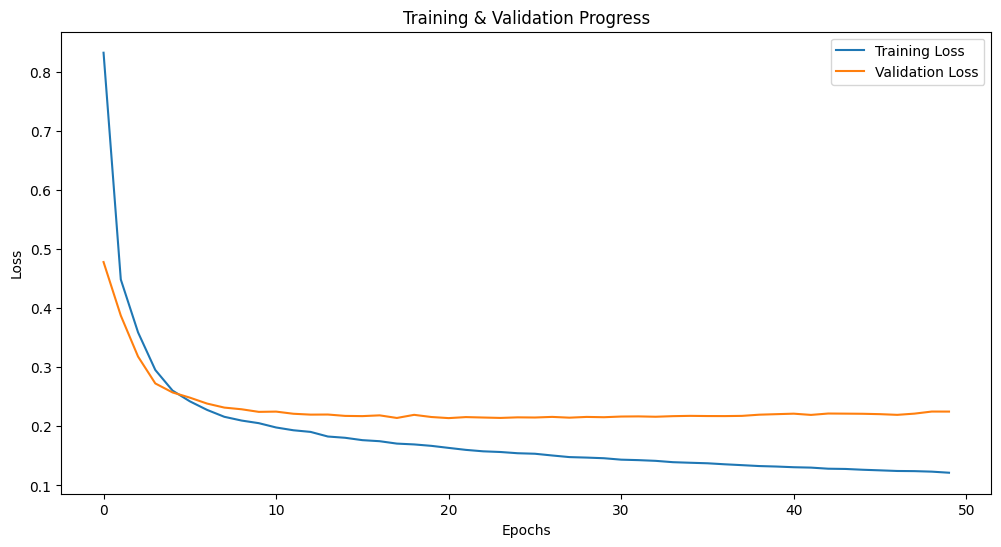

In [ ]:
# Plotting training progress
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
#plt.ylim(0, 1)
plt.legend()
plt.title("Training & Validation Progress")
plt.show()

#Saving Model - Qualitative Evaluation

In [ ]:
torch.save(model.state_dict(), '/content/BRAIN-TUMOR-1/maskrcnn_brain_weights.pth')

In [ ]:
import os
import random
import json
import numpy as np
import skimage.draw
from torchvision import transforms

num_classes = 2  # 1 class (brain tumor) + 1 background
model = maskrcnn_resnet50_fpn(pretrained=False, num_classes=num_classes)
model.load_state_dict(torch.load('/content/BRAIN-TUMOR-1/maskrcnn_brain_weights.pth'))
model = model.to(device)
model.eval()  # Set the model to evaluation mode

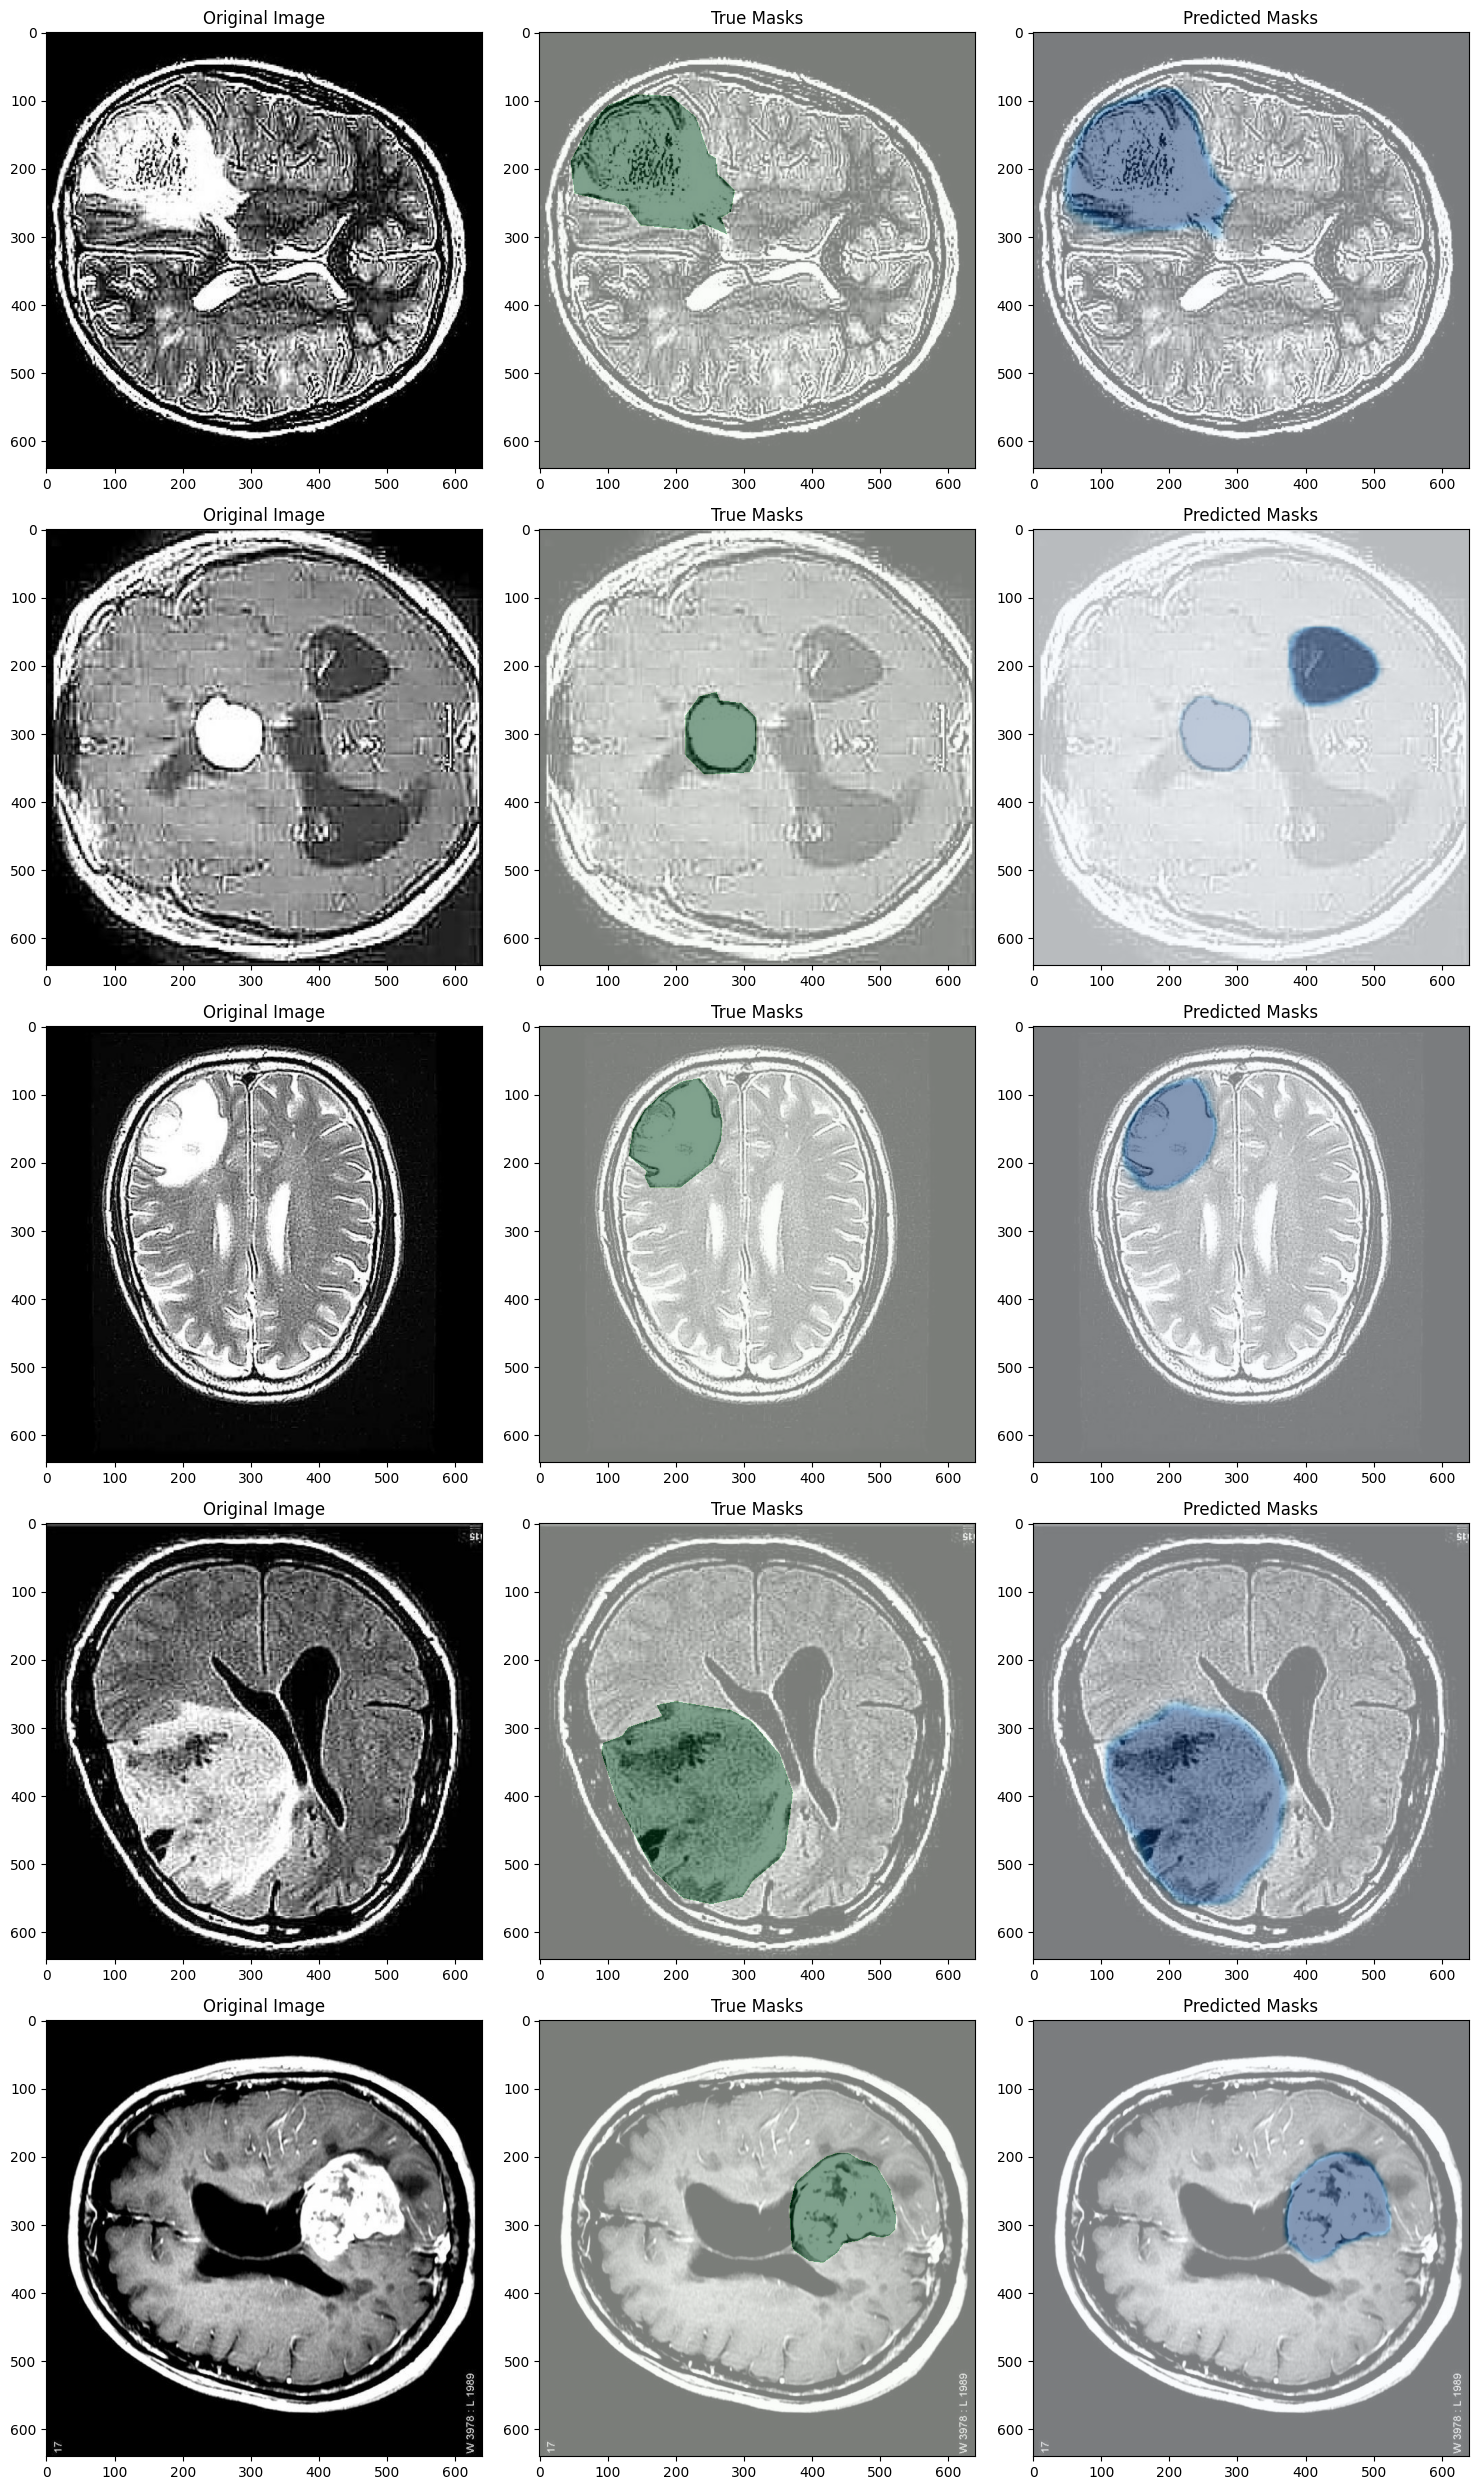

In [ ]:
def predict_and_plot(model, image_path, true_masks=None, threshold=0.5, ax=None):
    image = Image.open(image_path).convert("RGB")
    test_transform = transforms.Compose([transforms.ToTensor()])
    image_tensor = test_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = model(image_tensor)

    pred_masks = prediction[0]['masks'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()
    pred_masks = pred_masks[scores >= threshold]

    ax[0].imshow(image)
    ax[0].set_title("Original Image")

    ax[1].imshow(image)
    if true_masks is not None:
        for mask in true_masks:
            ax[1].imshow(mask, alpha=0.5, cmap='Greens')
    ax[1].set_title("True Masks")

    ax[2].imshow(image)
    for mask in pred_masks:
        ax[2].imshow(mask[0], alpha=0.5, cmap='Blues')
    ax[2].set_title("Predicted Masks")


with open('/content/BRAIN-TUMOR-1/test/_annotations.coco.json', 'r') as f:
    annotations = json.load(f)


image_ids = [img["id"] for img in annotations["images"]]
selected_image_ids = random.sample(image_ids, 5)


fig, axes = plt.subplots(5, 3, figsize=(15, 25))

for idx, image_id in enumerate(selected_image_ids):
    image_info = next(img for img in annotations["images"] if img["id"] == image_id)
    image_path = os.path.join('/content/BRAIN-TUMOR-1/test', image_info["file_name"])


    true_masks = []
    for ann in annotations["annotations"]:
        if ann["image_id"] == image_id:
            mask = np.zeros((image_info["height"], image_info["width"]))
            for seg in ann["segmentation"]:
                poly = np.array(seg).reshape((-1, 2))
                rr, cc = skimage.draw.polygon(poly[:, 1], poly[:, 0])
                mask[rr, cc] = 1
            true_masks.append(mask)

    predict_and_plot(model, image_path, true_masks, ax=axes[idx])

plt.tight_layout()
plt.show()